<a href="https://colab.research.google.com/github/McMafia/ADMMBO/blob/main/ADMMBO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

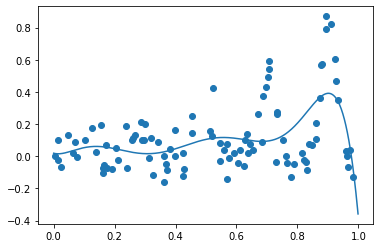

>x=0.902, f()=0.391158, actual=0.863
>x=0.903, f()=0.426314, actual=0.704
>x=0.176, f()=0.055809, actual=-0.177
>x=0.350, f()=0.021044, actual=-0.062
>x=0.505, f()=0.114744, actual=0.226
>x=0.240, f()=0.014012, actual=-0.010
>x=0.898, f()=0.445255, actual=0.572
>x=0.902, f()=0.454654, actual=0.663
>x=0.453, f()=0.095140, actual=0.061
>x=0.751, f()=0.119603, actual=0.039
>x=0.902, f()=0.467526, actual=0.826
>x=0.905, f()=0.488158, actual=0.697
>x=0.935, f()=0.434433, actual=0.451
>x=0.659, f()=0.076630, actual=0.176
>x=0.903, f()=0.499611, actual=0.815
>x=0.897, f()=0.511825, actual=0.764
>x=0.745, f()=0.104180, actual=-0.089
>x=0.428, f()=0.080958, actual=0.156
>x=0.456, f()=0.108416, actual=-0.011
>x=0.791, f()=0.196779, actual=0.138
>x=0.210, f()=0.023979, actual=-0.032
>x=0.906, f()=0.527259, actual=0.876
>x=0.907, f()=0.543039, actual=0.817
>x=0.660, f()=0.064999, actual=0.396
>x=0.756, f()=0.117893, actual=0.075
>x=0.907, f()=0.553036, actual=0.696
>x=0.906, f()=0.559052, actual=0

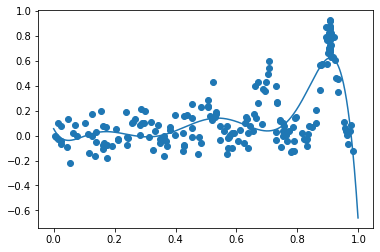

Best Result: x=0.907, y=0.924


In [1]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import numpy as np
# objective function
def objective(x, noise=0.1):
	noise = normal(loc=0, scale=noise)
	return (x**2 * sin(5 * pi * x)**6.0) + noise

# surrogate or approximation for the objective function
def surrogate(model, X):
	# catch any warning generated when making a prediction
	with catch_warnings():
		# ignore generated warnings
		simplefilter("ignore")
		return model.predict(X, return_std=True)

# probability of improvement acquisition function
def acquisition(X, Xsamples, model):
	# calculate the best surrogate score found so far
	yhat, _ = surrogate(model, X)
	best = max(yhat)
	# calculate mean and stdev via surrogate function
	mu, std = surrogate(model, Xsamples)
	mu = mu[:, 0]
	# calculate the probability of improvement
	probs = norm.cdf((mu - best) / (std+1E-9))
	return probs

# optimize the acquisition function
def opt_acquisition(X, y, model):
	# random search, generate random samples
	Xsamples = random(100)
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	# calculate the acquisition function for each sample
	scores = acquisition(X, Xsamples, model)
	# locate the index of the largest scores
	ix = argmax(scores)
	return Xsamples[ix, 0]

# plot real observations vs surrogate function
def plot(X, y, model):
	# scatter plot of inputs and real objective function
	pyplot.scatter(X, y)
	# line plot of surrogate function across domain
	Xsamples = asarray(arange(0, 1, 0.001))
	Xsamples = Xsamples.reshape(len(Xsamples), 1)
	ysamples, _ = surrogate(model, Xsamples)
	pyplot.plot(Xsamples, ysamples)
	# show the plot
	pyplot.show()

# sample the domain sparsely with noise
X = random(100)
y = asarray([objective(x) for x in X])
# reshape into rows and cols
X = X.reshape(len(X), 1)
y = y.reshape(len(y), 1)
# define the model
model = GaussianProcessRegressor()
# fit the model
model.fit(X, y)
# plot before hand
plot(X, y, model)
# perform the optimization process
for i in range(100):
	# select the next point to sample
	x = opt_acquisition(X, y, model)
	# sample the point
	actual = objective(x)
	# summarize the finding
	est, _ = surrogate(model, [[x]])
	print('>x=%.3f, f()=%3f, actual=%.3f' % (x, est, actual))
  #print(abs(est-actual))
	# add the data to the dataset
	X = vstack((X, [[x]]))
	y = vstack((y, [[actual]]))
	# update the model
	model.fit(X, y)

# plot all samples and the final surrogate function
plot(X, y, model)
# best result
ix = argmax(y)
print('Best Result: x=%.3f, y=%.3f' % (X[ix], y[ix]))

In [6]:
from math import sin
from math import pi
from numpy import arange
from numpy import vstack
from numpy import argmax
from numpy import asarray
from numpy.random import normal
from numpy.random import random
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from warnings import catch_warnings
from warnings import simplefilter
from matplotlib import pyplot
import numpy as np

In [28]:
class problem:
  
  def __init__(self,K,dim,n,m,delta,rho,eps,M,y1,z1,num_constraint,alpha,beta,bounds,model_opt,model_feas,F,X,C,Z):
    self.ADMM_iter=K
    self.dim=dim
    self.n=n
    self.m=m
    self.delta=delta
    self.rho=rho
    self.eps=eps
    self.M=M
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    self.num_constraint=num_constraint
    self.X=X
    self.beta=beta
    self.B=bounds
    self.U=[]
    self.F=F
    self.model_opt=model_opt
    self.model_feas=model_feas
    self.C=C
    self.Z=Z

  def obj_func(self,vec):
    self.vec=vec
    return -(np.cos((vec[0]-0.1)*vec[1]))**2-vec[0]*np.sin(3*vec[0]+vec[1])

  def constr_func(self,vec):
    t=np.arctan(vec[0]/(vec[1]+1E-9))
    return vec[0]*vec[0]+vec[1]*vec[1]-(2*np.cos(t)-0.5*np.cos(2*t)-0.25*np.cos(3*t)-0.125*np.cos(4*t))**2 - (2*np.sin(t))**2
  
  def OPT(self,alpha,y1,z1):
    self.alpha=alpha
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    
    U=np.zeros(self.n)
    U=U.reshape((self.n,-1))
    for i in range(self.n):
      U[i]=self.F[i]+(self.rho/2)*(np.linalg.norm(self.X[i]-self.z1+self.y1/self.rho))**2

    for t in range(alpha):
      model_opt.fit(self.X,U)
      Xsamples=np.random.uniform(self.B[0][0],self.B[0][1],(200,self.dim))
      

      mu,std=self.surrogate_X(model_opt,Xsamples)
      mu=np.array(mu)
      std=np.array(std)
      
      best=min(U)
      
      l=np.empty((0,1),float)
      probs=np.empty((0,1),float)

  #doubt here    
      for i in range(200):
        l=np.vstack((l,(best-mu[i])/(std[i]+1E-9)))
        #probs = np.vstack((probs,norm.cdf((best-mu[i]) / (std[i]+1E-9))))
        probs=np.vstack((probs,std[i]*(l[i]*norm.cdf(l[i])+norm.pdf((l[i])))))

      ix=np.argmax(probs)
      self.X=np.vstack((self.X,Xsamples[ix]))
      self.F=np.vstack((self.F,self.obj_func(Xsamples[ix])))
      
      U=np.vstack((U,self.obj_func(Xsamples[ix])+self.rho/2*(np.linalg.norm(Xsamples[ix]-self.z1+self.y1/self.rho))**2))
     
      ##############

      self.n=self.n+1


    index=np.argmin(U)

    return self.X[index]

  def FEAS(self,ix,xmin,y1,z1):
    H=np.zeros((self.m[ix],1))
    H.reshape((self.m[ix],-1))
    self.y1=np.mean(y1,axis=0)
    self.z1=np.mean(z1,axis=0)
    
    for i in range(self.m[ix]):
      H[i]=5*int(self.C[ix][i]>0)+(self.rho/(2*self.M))*(np.linalg.norm(xmin-self.Z[ix][i]+self.y1/self.rho))**2
    
    hplus=min(H)
    #print(H)
    for t in range(self.beta[ix]):
      model_feas[ix].fit(self.Z[ix][0:self.m[ix]],self.C[ix][0:self.m[ix]])
      Zsamples=np.random.uniform(self.B[0][0],self.B[0][1],(100,self.dim))
      mu,std=self.surrogate_Z(model_feas[ix],Zsamples)
      
      theta=np.zeros(100)
      theta.reshape((100,-1))
      
      probs=np.zeros(100)
      
      for i in range(100):
        
        theta[i] = 1-norm.cdf(-mu[i]/std[i])
        
        if hplus - (self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2 <= 0:
          probs[i]=0
        
        if hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2>0 and hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2<=1:
          probs[i]= (hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2)*(1-theta[i])
        
        if hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2>1:
          probs[i]= (hplus-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2)*(1-theta[i])+theta[i]*(hplus-1-(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[i]+self.y1/self.rho))**2)

      idx=np.argmax(probs)
      #print(theta)
      Zsamples=Zsamples.reshape(100,2)

      self.Z[ix][self.m[ix]]=Zsamples[idx]
      h=int(self.constr_func(Zsamples[idx]>0))+(self.rho/(2*self.M))*(np.linalg.norm(xmin-Zsamples[idx]+self.y1/self.rho))**2

      H=np.vstack((H,np.array([h])))
      self.C[ix][self.m[ix]]=self.constr_func(Zsamples[idx])

      self.m[ix]=self.m[ix]+1

    zmin=np.argmin(H)
      
    zmin=(self.Z[ix][zmin])
    
    return zmin  

  def surrogate_X(self,model, X):
	 
    # catch any warning generated when making a prediction
  	with catch_warnings():
		  # ignore generated warnings
	  	simplefilter("ignore")
	  	return model.predict(X, return_std=True)
    
  def surrogate_Z(self,model, Zsamples):
	 
    # catch any warning generated when making a prediction
  	with catch_warnings():
		  # ignore generated warnings
	  	simplefilter("ignore")
	  	return model.predict(Zsamples, return_std=True)
    
      

In [29]:
#initializing parameters
K=100
dim=2
n=4
m=np.array([4])
delta=0.5
rho=0.1
eps=0.01
M=40


N=1

bound=[(-2.25,2.25),(-2.25,2.25)]

#creating the random initial vectors for ADMM
y1=np.full((N,dim),0.0)
z1=np.full((N,dim),0.0)



#defining the model
model_opt = GaussianProcessRegressor()
model_feas=[GaussianProcessRegressor() for i in range(N)]



#budgets for each of the iterations
alpha=np.random.randint(2,5,K)
alpha[0]=20
beta=np.random.randint(2,5,N)
beta[0]=20

F=np.zeros(n)
F=F.reshape((n,-1))
X = np.zeros((n,dim))
C=np.zeros((N, np.max(m)+np.max(beta)*K))
Z = np.zeros((N, np.max(m)+K*np.max(beta), dim))

prob=problem(K,dim,n,m,delta,rho,eps,M,y1,z1,N,alpha,beta,bound,model_opt,model_feas,F,X,C,Z)

for i in range(prob.num_constraint):
  for j in range(prob.m[i]):
    prob.Z[i][j]=np.random.uniform(-2.25,2.5,size=(dim))
    prob.C[i][j]=prob.constr_func(Z[i][j])
answers=np.zeros((K+1,dim))
for i in range(n):
   prob.X[i]=(np.random.uniform(-2.25,2.5,prob.dim))

   prob.F[i]=prob.obj_func(prob.X[i])

In [30]:
def ADMMBO():
 
  S=False
  k=0
  zstar=np.zeros((N,dim))
  r=np.full((N,2),1e9)
  s=np.full((N,2),1e9)
  mini=1e9+0.1
  xstar=np.array([0.0,0.0])
  while k<prob.ADMM_iter and S==False:
    print(k)
    xstar=prob.OPT(alpha[k],y1,z1)
    zprev=np.mean(z1,axis=0)
    for i in range(prob.num_constraint):
      
      
      z1[i]=prob.FEAS(i,xstar,y1,z1)
      y1[i]=y1[i]+prob.rho*(xstar-z1[i])
      
      r[i]=xstar-z1[i]
      s[i]=-prob.rho*(z1[i]-zprev)
      
      zprev=z1[i]
                      
    
    if np.linalg.norm(r) <=prob.eps and np.linalg.norm(s) <=prob.eps:
      S=True
    k=k+1   
    if(np.linalg.norm(r)>=10*np.linalg.norm(s)):
      prob.rho=2*prob.rho

    if(np.linalg.norm(s)>=np.linalg.norm(r)*10):
      prob.rho=prob.rho/2
    
    answers[k]=xstar
    print(xstar,np.linalg.norm(r),np.linalg.norm(s))
    if(prob.constr_func(xstar)<=0):
      print('yesssssssss')
    
    
      

    if S==True:
      print(xstar,"answer is here!!!!!")    
    
      

In [31]:
ADMMBO()

0
[-2.20956711 -1.2938035 ] 2.29611257361298 0.16695436454907803
1
[ 1.48895288 -2.15498301] 1.1024911015357193 0.12345802490296663
2
[2.23694276 1.32870579] 0.5270703799846373 0.5387121511673685
3
[2.23694276 1.32870579] 0.313770123440536 0.0827186552438622
4
[2.23694276 1.32870579] 1.7593726016160292 0.2914262160683516
5
[-2.20956711 -1.2938035 ] 2.2770953431973666 0.47400895967366546
6
[-2.20956711 -1.2938035 ] 2.922403698737361 0.21858823645067
7
[2.23694276 1.32870579] 1.6093474794593046 0.3493313743979074
8
[2.23694276 1.32870579] 0.224951014586299 0.5990191861322011
9
[2.23694276 1.32870579] 0.5561840260700666 0.2820274400903981
10
[2.23694276 1.32870579] 0.17548162181771487 0.29264976404312454
11
[2.1745449  1.43402056] 0.881178529674178 0.37419071428628
12
[2.10686944 1.5311527 ] 0.04699908088257307 0.3107886630215038
13
[2.09736572 1.57547579] 0.711305059544355 0.2853751985548288
14
[2.1745449  1.43402056] 1.6266781575375129 0.5829918342695002
15
[-2.20956711 -1.2938035 ] 2.8

In [8]:

import matplotlib.pyplot as plt
import numpy as np



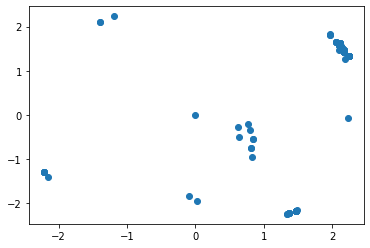

In [32]:
plt.scatter(answers[:,0],answers[:,1])

In [34]:
for i in range(prob.X.size):
  if(prob.constr_func(prob.X[i])<0 and prob.obj_func(prob.X[i])<-1.5):
    print(prob.X[i],prob.obj_func(prob.X[i]))

[ 0.80445111 -0.2214721 ] -1.6300737219706243
[-1.94805768 -1.26333238] -2.1530759384309257
[-0.63246682  0.33102898] -1.5748131398048888
[ 0.79858728 -0.34755651] -1.651494174966722
[-2.07097213 -0.85505315] -1.5428188105066383
[ 0.5985331  -0.47368924] -1.5253529677201505
[ 0.63429323 -0.51148516] -1.5512703807491453
[-0.80750427  0.16998735] -1.6034050945183278
[-1.89685019 -1.32924018] -2.055011091683863
[ 0.62103451 -0.275052  ] -1.6005440702312626
[-0.65580478  0.22957473] -1.6168703630454213
[ 0.83468175 -0.5461631 ] -1.620377418987757
[-1.8602476  -1.31516154] -1.7844572483690162
[ 0.77243676 -0.1305433 ] -1.6227870260508475
[ 0.81614924 -0.74316495] -1.551279292792409
[-1.94706406 -1.10788948] -1.6150106483548488
[ 0.76582832 -0.21398974] -1.6471973466833647
[1.95459708 1.24672127] -1.8948556587430712
[ 0.80718925 -0.30134751] -1.6436591989019629


IndexError: ignored

In [36]:
prob.obj_func([1.94,1.26])

-1.8495999578371507

In [ ]:
prob.X.shape

(322, 2)

In [ ]:
3/2*3

4.5